In [47]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Convolution2D, MaxPooling2D, Flatten, Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import cv2

import numpy as np
import csv
import matplotlib.pyplot as plt
%matplotlib inline

import time
import pickle

In [ ]:
def load_center_data(dat_dir):
    # load the data
#     data_dir = "./data/track1/20170304/"
#     t = time.time()
    X_train = []
    y_train = []

    with open(data_dir + "driving_log.csv") as csv_file:
        reader = csv.reader(csv_file)
    #     next(reader, None)
        for line in reader:
            X_train.append(cv2.imread(line[0])) # center image
            y_train.append(float(line[3]))  # steering angels 
    X_train = np.array(X_train)
    y_train = np.array(y_train)
#     print("Time: " + str(time.time() - t)) 

In [75]:
def load_3_camera_data(data_dir, correction_steer=0.2):
    # load the data
    # TODO: use generator, how much memory required???
#     data_dir = "./data/track1/20170304/"
#     t = time.time()
    X_train = []
    y_train = []

    with open(data_dir + "driving_log.csv") as csv_file:
        reader = csv.reader(csv_file)
#         count = 0
        for line in reader:
#             if count == 10:
#                 break
#             count += 1
            steer_center = float(line[3])
            X_train.extend([cv2.imread(line[i].strip()) for i in range(3) ]) # center, left, right'\
            y_train.extend([steer_center, steer_center + correction_steer, steer_center - correction_steer])
    return np.array(X_train), np.array(y_train)

In [76]:
# data_dir = "./data/track1/20170304/"
t = time.time()
X_train, y_train = load_3_camera_data("./data/track1/20170304/")
print("Time: " + str(time.time() - t)) 


Time: 105.09217977523804


In [74]:
X_train.shape

(30, 160, 320, 3)

In [67]:
X_train[1].shape

(160, 320, 3)

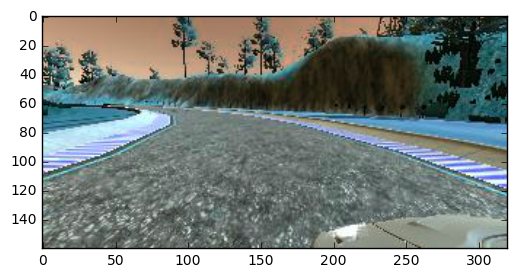

In [68]:
plt.imshow(X_train[1])

In [14]:
# build the model

model = Sequential()
model.add(Lambda(lambda x : x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=10, callbacks=[early_stopping])
model.save("model.h5")

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 8s - loss: 10.0669 - val_loss: 0.9585
Epoch 2/10
1600/1600 [==============================] - 5s - loss: 2.1819 - val_loss: 1.1985
Epoch 3/10
1600/1600 [==============================] - 5s - loss: 0.9231 - val_loss: 0.6219
Epoch 4/10
1600/1600 [==============================] - 6s - loss: 1.0859 - val_loss: 0.5281
Epoch 5/10
1600/1600 [==============================] - 6s - loss: 1.1395 - val_loss: 2.2876
Epoch 6/10
1600/1600 [==============================] - 5s - loss: 1.8426 - val_loss: 1.0135
Epoch 7/10
1600/1600 [==============================] - 5s - loss: 1.2017 - val_loss: 0.4872
Epoch 8/10
1600/1600 [==============================] - 5s - loss: 1.6273 - val_loss: 1.6809
Epoch 9/10
1600/1600 [==============================] - 5s - loss: 2.4382 - val_loss: 2.1647
Epoch 10/10
1600/1600 [==============================] - 6s - loss: 5.5575 - val_loss: 4.9473


In [11]:
model = Sequential()
model.add(Lambda(lambda x : x/255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Convolution2D(6, 5, 5, border_mode="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(16, 5, 5, border_mode="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(120))
# model.add(Activation("relu"))

model.add(Dense(84))
# model.add(Activation("relu"))

model.add(Dense(1))
# model.add(Activation("softmax"))

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = SGD(lr=0.001)
model.compile(loss='mse', optimizer="adam")
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, batch_size=120)
model.save("model-lenet.h5")


Train on 2677 samples, validate on 670 samples
Epoch 1/5
2677/2677 [==============================] - 378s - loss: 196.6639 - val_loss: 5.9650
Epoch 2/5
2677/2677 [==============================] - 353s - loss: 1.1585 - val_loss: 0.0563
Epoch 3/5
2677/2677 [==============================] - 362s - loss: 0.0639 - val_loss: 0.0726
Epoch 4/5
2677/2677 [==============================] - 431s - loss: 0.0665 - val_loss: 0.0660
Epoch 5/5
2677/2677 [==============================] - 261s - loss: 0.0595 - val_loss: 0.0596
